In [138]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

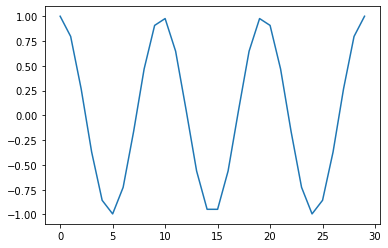

In [141]:
wave = np.genfromtxt('babes/wave.csv', delimiter=',')
estimated_sampling_frequency = 30 #sampling_frequency; changes the anplitude, not the shape of the curve

n = wave.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = wave.shape[0])

plt.plot(wave)

In [142]:
sp = np.fft.fft(wave, n, norm = 'ortho')
freq = np.fft.fftfreq(n, d = 1/estimated_sampling_frequency)

In [143]:
frequencies = pd.DataFrame(freq, columns=['Frequency'])
frequencies['Amplitude'] = np.abs(sp)/sample_count
frequencies['Phase'] = np.angle(sp)
frequencies['Real'] = np.real(sp)
frequencies['Imaginary'] = np.imag(sp)
frequencies['wave'] = sp
frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
frequencies.set_index('Frequency', inplace=True)
frequencies.head()

,Amplitude,Phase,Real,Imaginary,wave
Frequency,,,,,
2.0,0.310037,0.209440,0.303262,0.064460,0.303262+0.064460j
3.0,2.739575,0.314159,2.605490,0.846575,2.605490+0.846575j
-3.0,2.739575,-0.314159,2.605490,-0.846575,2.605490-0.846575j
-2.0,0.310037,-0.209440,0.303262,-0.064460,0.303262-0.064460j


In [144]:
def get_frequencencies(wave_data, sampling_frequency):
    n = wave_data.shape[0]
    sample_count = (n/sampling_frequency) # estimated samples
    print(sample_count)
    sp = np.fft.fft(wave_data, n, norm = 'ortho')
    freq = np.fft.fftfreq(n, d = 1/sampling_frequency)
    
    frequencies = pd.DataFrame(freq, columns=['Frequency'])
    frequencies['Amplitude'] = np.abs(sp)/sample_count
    frequencies['Phase'] = np.angle(sp)
    frequencies['Real'] = np.real(sp)
    frequencies['Imaginary'] = np.imag(sp)
    frequencies['wave'] = sp
    frequencies = frequencies[frequencies.Amplitude > 0.1*frequencies.Amplitude.max()] # Greater than 10% of the max amplitude
    frequencies.set_index('Frequency', inplace=True)
    return frequencies

In [145]:
# Create a function to get the frequencies of a wave
get_frequencencies(wave, estimated_sampling_frequency)

1.0


,Amplitude,Phase,Real,Imaginary,wave
Frequency,,,,,
2.0,0.310037,0.209440,0.303262,0.064460,0.303262+0.064460j
3.0,2.739575,0.314159,2.605490,0.846575,2.605490+0.846575j
-3.0,2.739575,-0.314159,2.605490,-0.846575,2.605490-0.846575j
-2.0,0.310037,-0.209440,0.303262,-0.064460,0.303262-0.064460j


### Wave Reconstruction

In [146]:
def reconstruct_wave(magnitudes, time):
    omega = np.reshape(2*np.pi*magnitudes.index,(magnitudes.shape[0],1))
    time = np.reshape(time,(1, time.shape[0]))
    return (np.cos((omega @ time)).T @ magnitudes)/2#*np.pi#*(n**0.1)) 
    # Scaling factor needed to make the wave have the same amplitude as the original wave

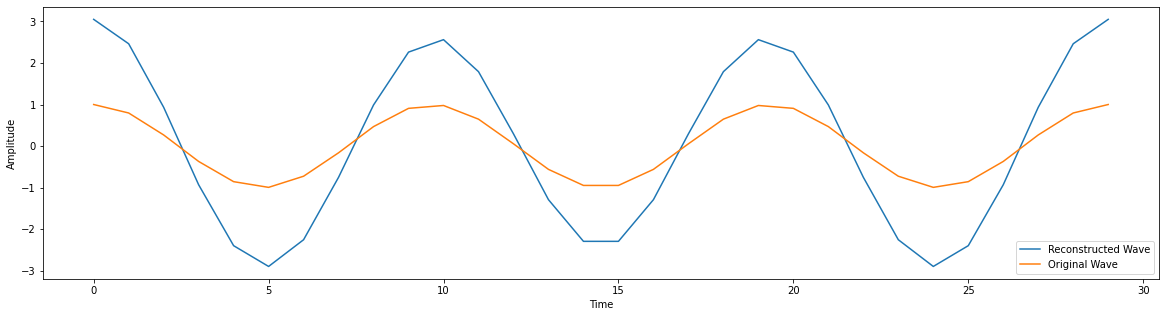

In [147]:
reconstructed_wave = reconstruct_wave(frequencies.Amplitude, time_arr)

plt.figure(figsize= (20,5))
plt.plot(reconstructed_wave, label='Reconstructed Wave')
plt.plot(wave, label='Original Wave')
# plt.plot(np.fft.ifft(frequencies['wave'], n, norm = 'ortho'), label='IFFT Wave') # Inacurate in reduced dimensions
plt.legend(loc = 4)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## FFT Regression

### Reading Data

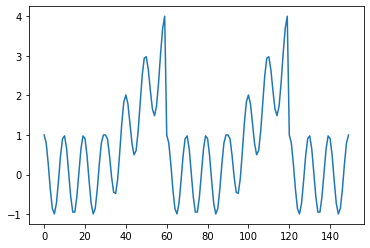

In [148]:
df = pd.read_csv('babes/wave_with_slope.csv')

estimated_sampling_frequency = 30 #sampling_frequency; changes the anplitude, not the shape of the curve

n = df.shape[0]
# n = 4
sample_count = (n/estimated_sampling_frequency) # estimated samples

time_arr = np.linspace(start = 0, stop = sample_count, num = wave.shape[0])

plt.plot(df)

### Breaking Data into Chunks/Seasonal Cycles

In [149]:
estimated_seasons = 5
season_length = n//estimated_seasons

seasons = {}

for i in range(estimated_seasons):
    seasons['season_'+str(i)] = df['0'].iloc[i*season_length :(i+1)*season_length].reset_index(drop=True)

seasons_df = pd.DataFrame(seasons)
seasons_df.reset_index(inplace=True)
seasons_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,0.796093,0.899541,0.796093,0.899541,0.796093
2,2,0.267528,0.474425,0.267528,0.474425,0.267528
3,3,-0.370138,-0.059793,-0.370138,-0.059793,-0.370138
4,4,-0.856857,-0.443064,-0.856857,-0.443064,-0.856857


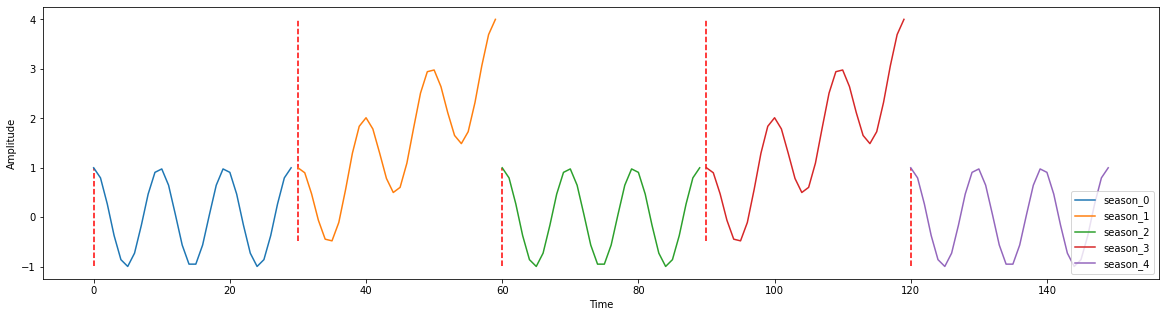

In [150]:
def plot_data(df):
    plt.figure(figsize= (20,5)) 
    for i, cols in enumerate(df.columns[1:]):
        plt.plot([i*season_length + j for j in range(season_length)], df[cols].values,label=cols)
        plt.vlines(i*season_length, df[cols].min(), df[cols].max(), color='r', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(loc = 4)
    plt.show()

plot_data(seasons_df)

### Remove Linear Trends in seasonal cycles

In [151]:
residuals_df = {}

for cols in seasons_df.columns[1:]:
    y, X = dmatrices(f'{cols} ~ index', data=seasons_df, return_type='dataframe')
    model = sm.OLS(y, X)       # Set up the model
    result = model.fit()       # Fit model (find the intercept and slopes)
    residuals_df[cols] = result.resid # Residuals
residuals_df = pd.DataFrame(residuals_df)
residuals_df.reset_index(inplace=True)
residuals_df.head()

,index,season_0,season_1,season_2,season_3,season_4
0,0,0.966667,0.966667,0.966667,0.966667,0.966667
1,1,0.762760,0.762760,0.762760,0.762760,0.762760
2,2,0.234195,0.234195,0.234195,0.234195,0.234195
3,3,-0.403471,-0.403471,-0.403471,-0.403471,-0.403471
4,4,-0.890191,-0.890191,-0.890191,-0.890191,-0.890191


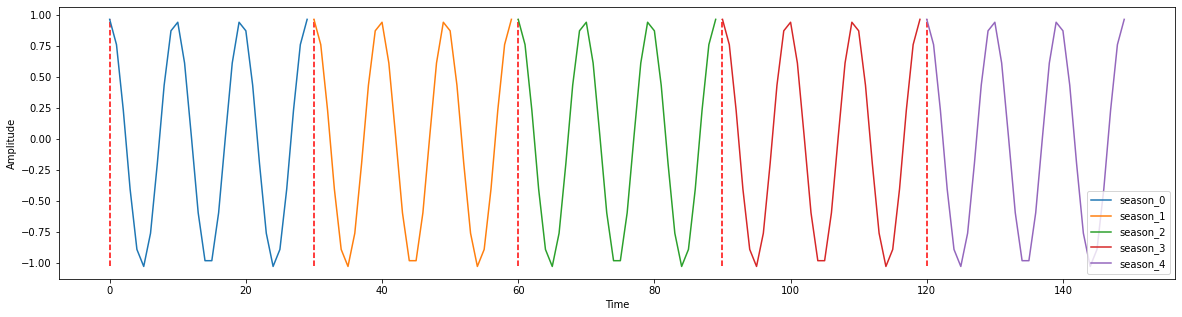

In [152]:
plot_data(residuals_df)

### Fourier Regression of seasonal cycles

In [153]:
_ = get_frequencencies(residuals_df.season_0, estimated_sampling_frequency)
_

1.0


,Amplitude,Phase,Real,Imaginary,wave
Frequency,,,,,
2.0,0.310037,0.209440,0.303262,0.064460,0.303262+0.064460j
3.0,2.739575,0.314159,2.605490,0.846575,2.605490+0.846575j
-3.0,2.739575,-0.314159,2.605490,-0.846575,2.605490-0.846575j
-2.0,0.310037,-0.209440,0.303262,-0.064460,0.303262-0.064460j


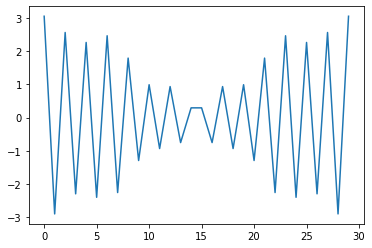

In [159]:
plt.plot(reconstruct_wave(_.Amplitude, time_arr[:season_length]))

In [160]:
time_arr[:season_length]

array([0.        , 0.17241379, 0.34482759, 0.51724138, 0.68965517,
       0.86206897, 1.03448276, 1.20689655, 1.37931034, 1.55172414,
       1.72413793, 1.89655172, 2.06896552, 2.24137931, 2.4137931 ,
       2.5862069 , 2.75862069, 2.93103448, 3.10344828, 3.27586207,
       3.44827586, 3.62068966, 3.79310345, 3.96551724, 4.13793103,
       4.31034483, 4.48275862, 4.65517241, 4.82758621, 5.        ])